# Data Analytics 1 - Assignment 2
## Team 31



### **Task 1 - Attribute-Oriented Induction**

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

df = pd.read_csv('Electric_Vehicle_Data.csv')
# df.head()
# ['County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range Category', 'Base MSRP', 'Legislative District', 'Electric Utility']

### 1. **Data Cleaning**
   - **Base MSRP Cleaning**: 
     - Any missing or zero values in the "Base MSRP" (Manufacturer's Suggested Retail Price) are replaced with the mean MSRP for cars of the same make and model. If there's still a missing value, it is filled with the overall mean.
   - **Electric Range Cleaning**: 
     - Similar to MSRP, missing or zero electric range values are replaced with the mean electric range of cars with the same make and model. If data is still missing, it fills in with the overall mean for that make.
     
#### **Remove Highly Specific Attributes**
   - Certain columns, such as VIN, census data, or specific location details, are dropped to generalize the data. This reduces noise from highly specific information that might not contribute to the desired high-level analysis.

#### **Categorization of Key Features**
   - **Electric Range**:
     - The electric range values are categorized into three levels: "low," "medium," and "high" based on the statistical quartiles of the range distribution.
   - **Model Year**:
     - The model year is bucketed into three categories: "Before 2015", "2015-2020", and "2021 and later."
   - **Base MSRP**:
     - The MSRP values are divided into four categories: "Low," "Medium," "High," and "Luxury."
   - **Make Hierarchy**:
     - The car makes are mapped to a hierarchy (Low, Mid, Luxury), indicating the market segment for each manufacturer.

#### **Region Mapping**
   - **State-to-Region Mapping**:
     - A dictionary is created that maps U.S. states (and other regions like "BC") to broader geographic regions (e.g., North, South, West). This mapping is applied to the dataset to assign each vehicle a region based on its state.


In [83]:
# Data Cleaning
# Replace 0 MSRP with Average of Cars with similar Make and Model
df['Base MSRP'] = df['Base MSRP'].replace(0, np.nan)
df['Base MSRP'] = df.groupby(['Make', 'Model'])['Base MSRP'].transform(lambda x: x.fillna(x.mean()))
df['Base MSRP'] = df['Base MSRP'].fillna(df['Base MSRP'].mean())

#  Replace 0 Electric Range with Average of Cars with similar Make and Model
df['Electric Range'] = df['Electric Range'].replace(0, np.nan)
df['Electric Range'] = df.groupby(['Make', 'Model'])['Electric Range'].transform(lambda x: x.fillna(x.mean()))
df['Electric Range'] = df.groupby('Make')['Electric Range'].transform(lambda x: x.fillna(x.mean()))

# Remove Highly Specific Attributes
generalised_data = df.drop(columns=['VIN (1-10)', 'DOL Vehicle ID', 'Vehicle Location', '2020 Census Tract', 'City', 'Postal Code', "Electric Utility", "Legislative District", "County", "Model"])

range_features = generalised_data["Electric Range"].describe()
bins = [0, range_features["25%"], range_features["75%"], range_features["max"]]
label_names = ["low", "medium", "high"]
generalised_data["Electric Range Category"] = pd.cut(generalised_data["Electric Range"], bins=bins, labels=label_names)

# Model Year 
bins_year = [0, 2014, 2020, 2025]
labels_year = ['Before 2015', '2015-2020', '2021 and later']
generalised_data['Model Year Category'] = pd.cut(generalised_data['Model Year'], bins=bins_year, labels=labels_year, include_lowest=True)

# Base MSRP
bins_msrp = [0, 50000, 60000, 80000, 150000]
labels_msrp = ['Low', 'Medium', 'High', 'Luxury']
generalised_data['Base MSRP Category'] = pd.cut(generalised_data['Base MSRP'], bins=bins_msrp, labels=labels_msrp, include_lowest=True)

make_hierarchy = {
    'CHEVROLET': 'Low', 'KIA': 'Low', 'NISSAN': 'Low', 'FIAT': 'Low', 'TOYOTA': 'Low', 'HONDA': 'Low', 
    'CHRYSLER': 'Low', 'SMART': 'Low', 'LINCOLN': 'Low', 'MINI': 'Low', 'MITSUBISHI': 'Low', 'HYUNDAI': 'Low', 
    'DODGE': 'Low', 'GENESIS': 'Low', 'SUBARU': 'Low', 'GMC': 'Low', 'WHEEGO ELECTRIC CARS': 'Low', 
    'TH!NK': 'Low', 'VOLVO': 'Mid', 'FORD': 'Mid', 'LEXUS': 'Mid', 'CADILLAC': 'Mid', 'MAZDA': 'Mid', 
    'VOLKSWAGEN': 'Mid', 'RIVIAN': 'Mid', 'POLESTAR': 'Mid', 'LAND ROVER': 'Mid', 'FISKER': 'Mid', 
    'AZURE DYNAMICS': 'Mid', 'JAGUAR': 'Luxury', 'MERCEDES-BENZ': 'Luxury', 'PORSCHE': 'Luxury', 
    'AUDI': 'Luxury', 'BENTLEY': 'Luxury', 'ROLLS ROYCE': 'Luxury', 'LUCID': 'Luxury', 'TESLA': 'Luxury', 
    'ALFA ROMEO': 'Luxury'
}
generalised_data['Make Category'] = generalised_data['Make'].map(make_hierarchy)

# Define the region mapping
region_mapping = {
    'North': ['WA', 'ID', 'MT', 'MN', 'WI', 'MI', 'ND', 'SD'],
    'East': ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA', 'DE', 'MD', 'DC', 'VA'],
    'South': ['TX', 'FL', 'GA', 'SC', 'NC', 'AL', 'MS', 'TN', 'LA', 'AR', 'KY'],
    'West': ['CA', 'OR', 'NV', 'UT', 'AZ', 'CO', 'NM', 'WY', 'AK', 'HI'],
    'Central': ['MO', 'IA', 'IN', 'IL', 'OH', 'NE', 'KS', 'OK'],
    'Other': ['AE', 'BC']
}

# Reverse the mapping for faster lookups
state_to_region = {state: region for region, states in region_mapping.items() for state in states}

# Apply the mapping to the DataFrame
generalised_data['Region'] = df['State'].map(state_to_region)

### **High-level Characteristic Rules**
   - The algorithm uses grouped data to identify common combinations of high-level features like region, electric vehicle type, electric range category, model year category, base MSRP category, and make category.
   - These combinations are counted, and the most frequent "rules" or patterns in the dataset are extracted by sorting them based on their frequency.


In [84]:
# Extract high-level characteristic rules by analyzing the generalized data
characteristic_rules = generalised_data.groupby(
    ['Region', 'Electric Vehicle Type', 'Electric Range Category', 'Model Year Category', 'Base MSRP Category', 'Make Category']
).size().reset_index(name='Count')

# Display the most common rules (sorting by count)
characteristic_rules.sort_values(by='Count', ascending=False).head(10)

/var/folders/b2/fpf7pzvd35zcmkv3xj4n_nbm0000gn/T/ipykernel_3646/2641113248.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  characteristic_rules = generalised_data.groupby(


,Region,Electric Vehicle Type,Electric Range Category,Model Year Category,Base MSRP Category,Make Category,Count
535,North,Battery Electric Vehicle (BEV),high,2021 and later,High,Luxury,34571
499,North,Battery Electric Vehicle (BEV),medium,2021 and later,High,Luxury,22944
487,North,Battery Electric Vehicle (BEV),medium,2015-2020,High,Luxury,17127
498,North,Battery Electric Vehicle (BEV),medium,2021 and later,High,Low,15679
486,North,Battery Electric Vehicle (BEV),medium,2015-2020,High,Low,11947
523,North,Battery Electric Vehicle (BEV),high,2015-2020,High,Luxury,7750
464,North,Battery Electric Vehicle (BEV),low,2021 and later,High,Mid,7698
570,North,Plug-in Hybrid Electric Vehicle (PHEV),low,2021 and later,High,Low,6587
500,North,Battery Electric Vehicle (BEV),medium,2021 and later,High,Mid,4977
474,North,Battery Electric Vehicle (BEV),medium,Before 2015,High,Low,4203


### **Graphs based on AOI**
   - Bar plots are generated to extract meaningful patterns and high-level insights, making it easier to analyze trends and characteristics across different attributes.

/var/folders/b2/fpf7pzvd35zcmkv3xj4n_nbm0000gn/T/ipykernel_3646/3909702186.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_counts, x='Count', y='Region', palette='viridis')


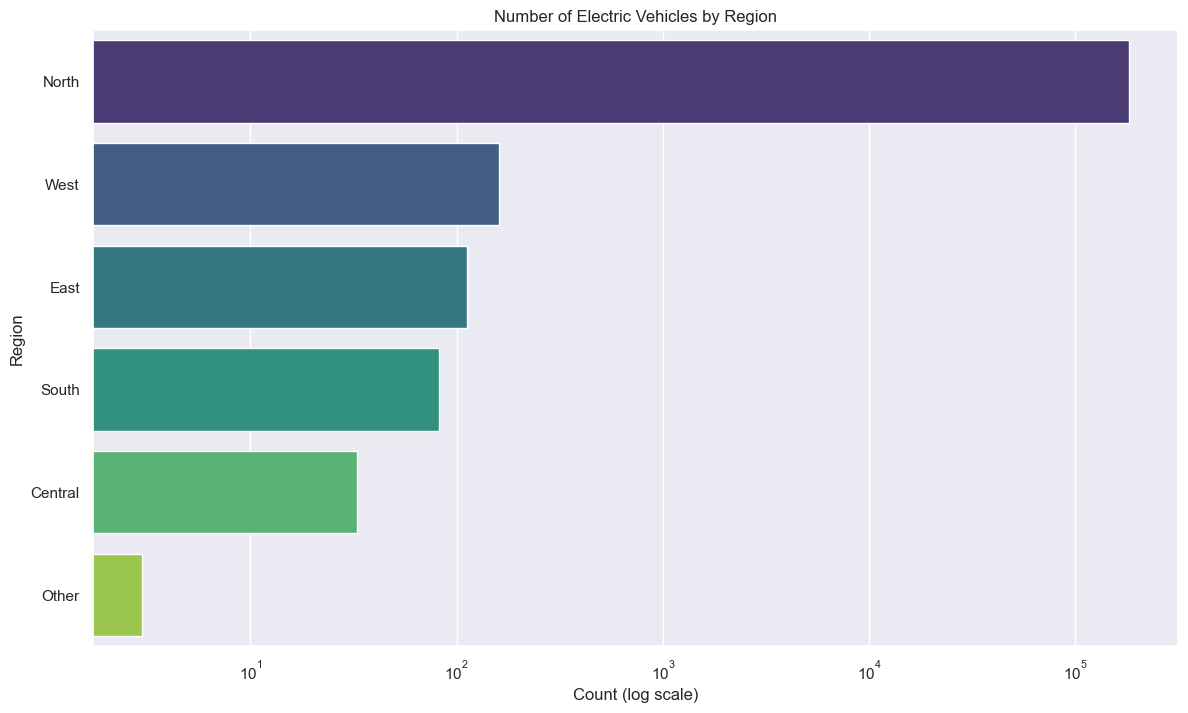

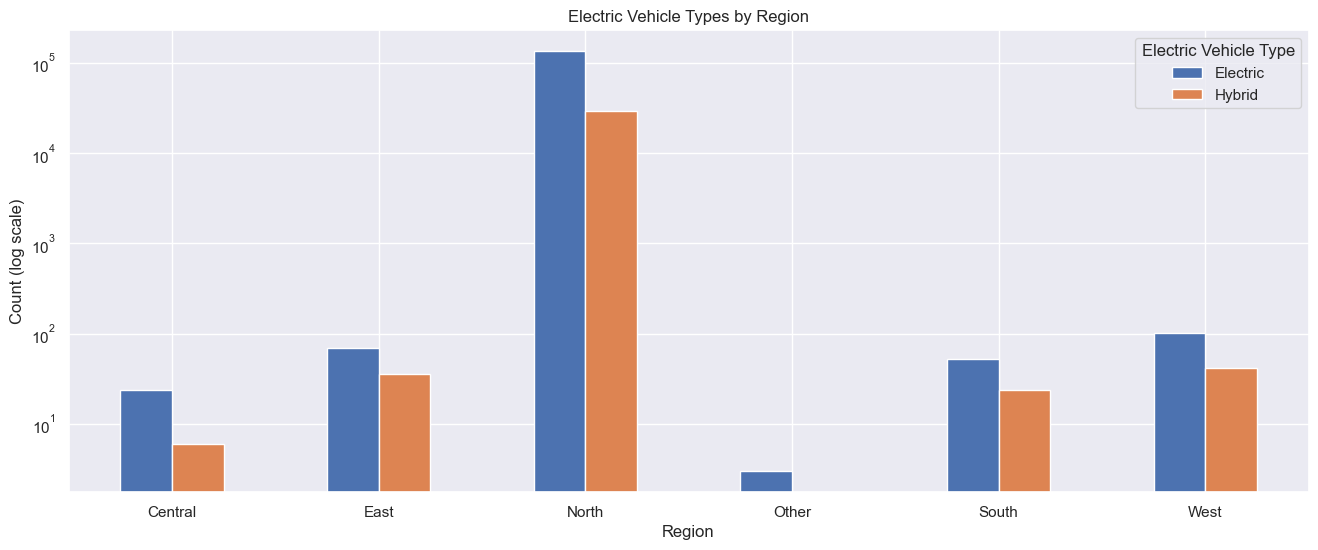

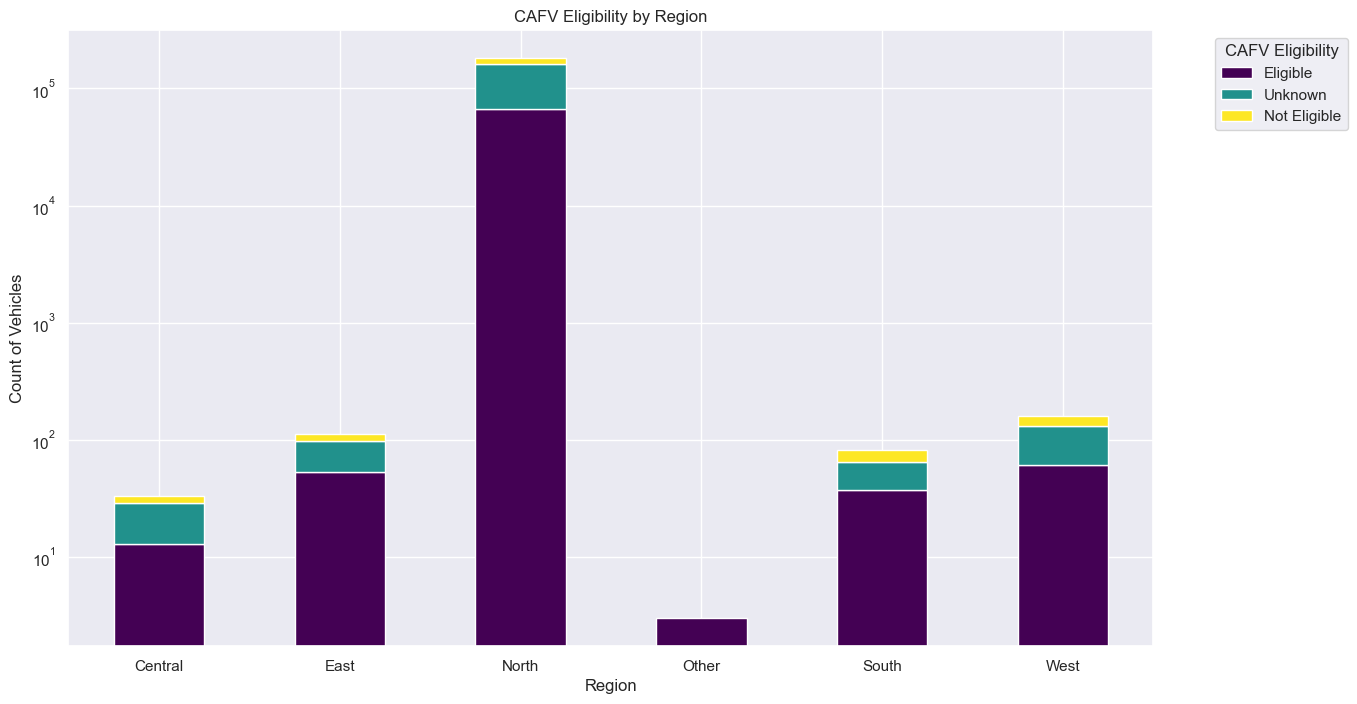

In [85]:
# Number of Electric Vehicles by Region
region_counts = generalised_data['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']
plt.figure(figsize=(14, 8))
sns.barplot(data=region_counts, x='Count', y='Region', palette='viridis')
plt.title('Number of Electric Vehicles by Region')
plt.xlabel('Count (log scale)')
plt.ylabel('Region')
plt.xscale('log')
plt.show()

# Region and Electric Vehicle Type 
ev_type_count = characteristic_rules.pivot_table(index='Region', columns='Electric Vehicle Type', values='Count', aggfunc='sum', fill_value=0)
ev_type_count.plot(kind='bar', figsize=(16, 6))
plt.xlabel('Region')
plt.xticks(rotation=0)
plt.ylabel('Count (log scale)')
plt.yscale('log')
plt.title('Electric Vehicle Types by Region')
plt.legend(title='Electric Vehicle Type', labels=['Electric', 'Hybrid'])
plt.show()

# CAFV eligibility by region
cafv_counts = generalised_data.groupby(['Region', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']).size().unstack(fill_value=0)
cafv_counts.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title('CAFV Eligibility by Region')
plt.xlabel('Region')
plt.xticks(rotation=0)
plt.ylabel('Count of Vehicles')
plt.yscale('log')
plt.legend(title='CAFV Eligibility', labels=['Eligible', 'Unknown', 'Not Eligible'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


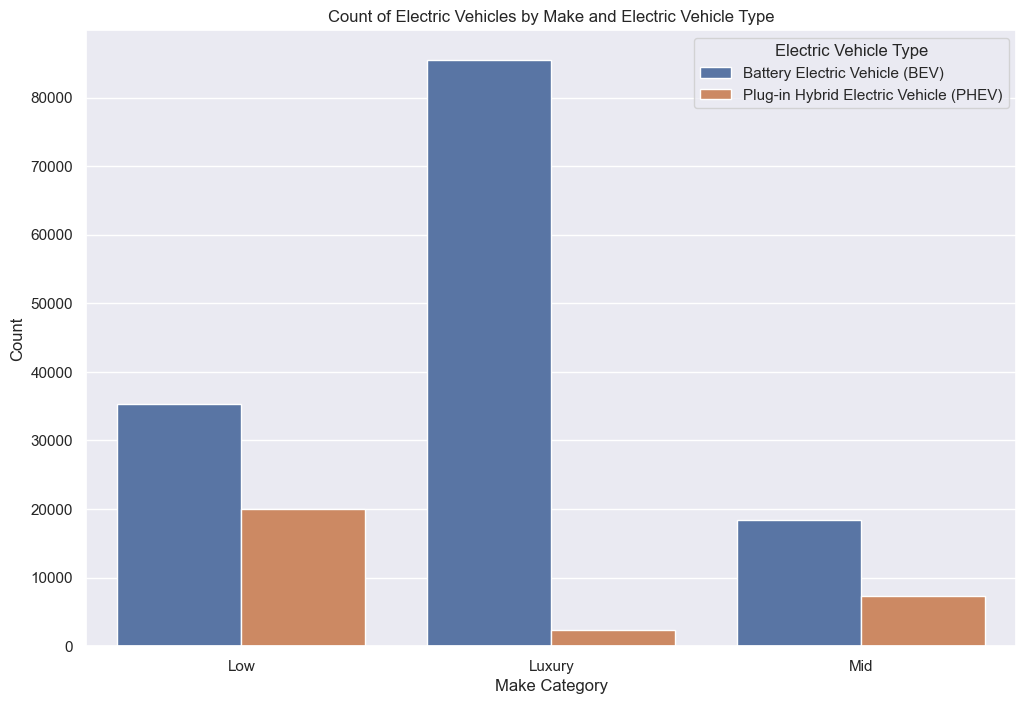

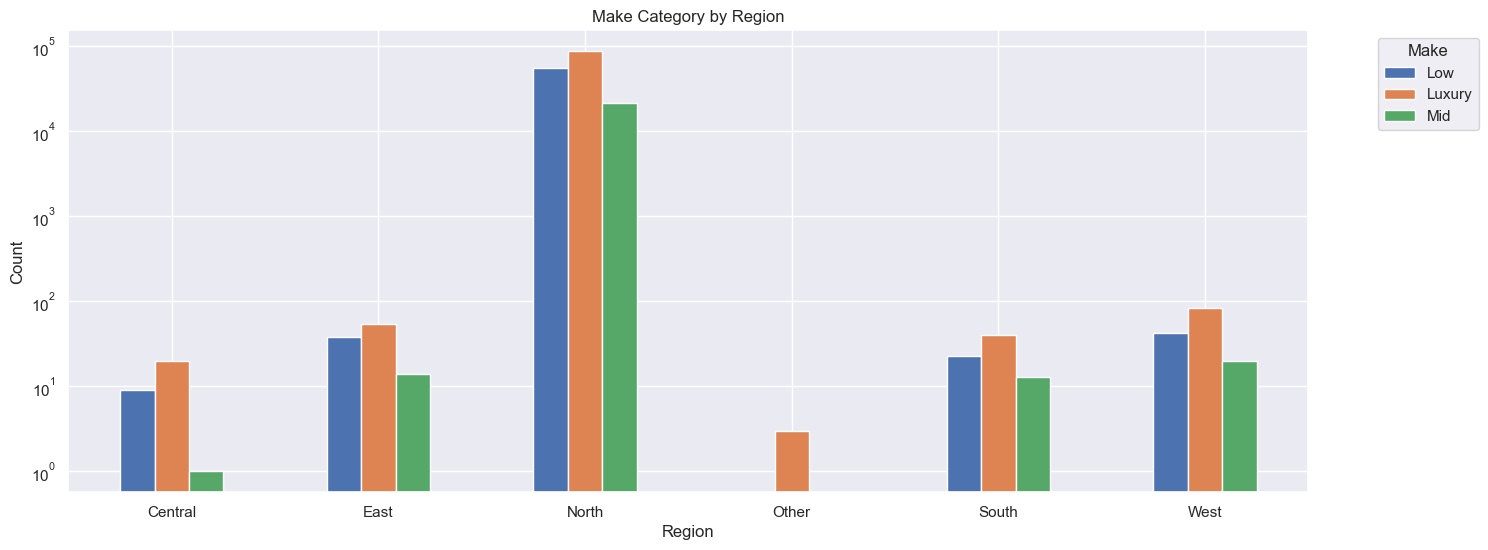

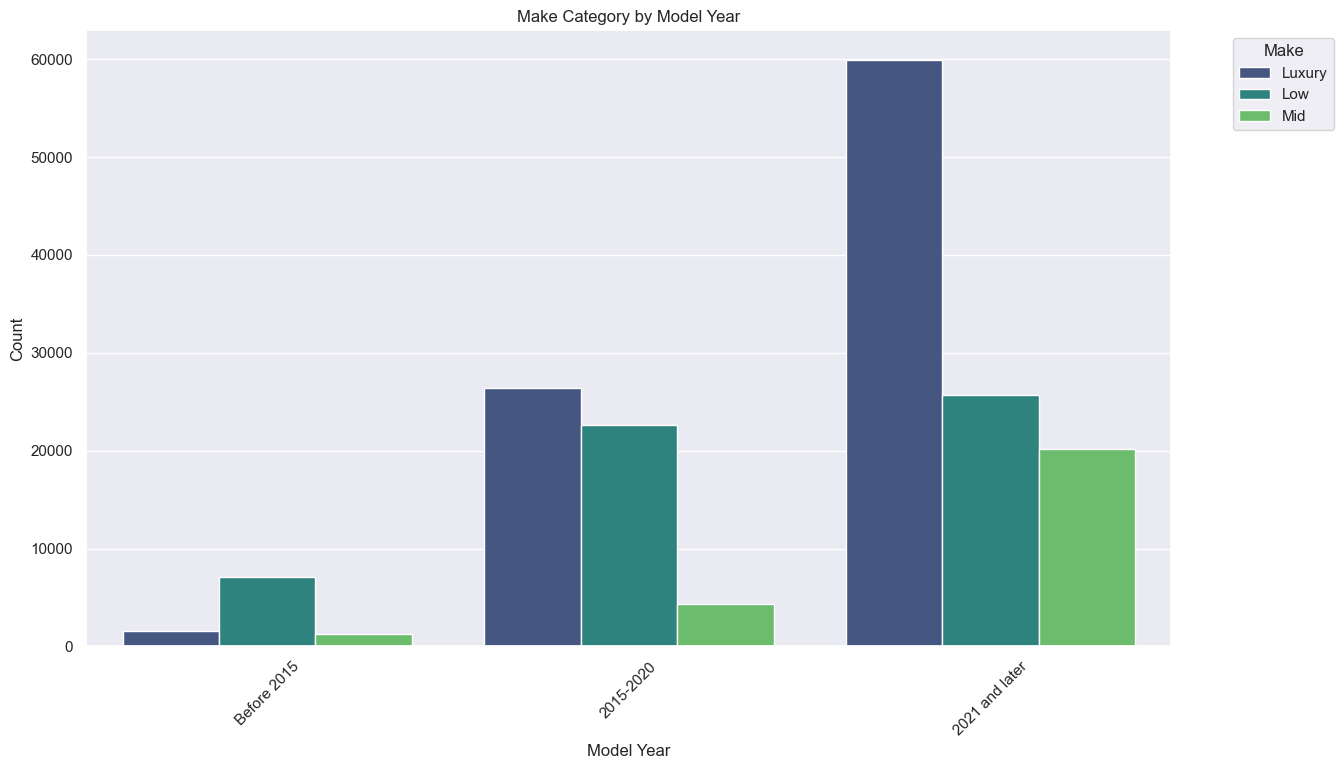

In [86]:
# Summarize the data
summary = generalised_data.groupby(['Make Category', 'Electric Vehicle Type']).size().reset_index(name='Count')
# Create a bar plot to visualize the summary data
plt.figure(figsize=(12, 8))
sns.barplot(data=summary, x='Make Category', y='Count', hue='Electric Vehicle Type')
plt.xlabel('Make Category')
plt.ylabel('Count')
plt.title('Count of Electric Vehicles by Make and Electric Vehicle Type')
plt.legend(title='Electric Vehicle Type')
plt.show()

make_count_by_region = characteristic_rules.pivot_table(index='Region', columns='Make Category', values='Count', aggfunc='sum', fill_value=0)

# Make vs Region
make_count_by_region.plot(kind='bar', figsize=(16, 6))
plt.xlabel('Region')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.yscale('log')
plt.title('Make Category by Region')
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(14, 8))
sns.countplot(data=generalised_data, x='Model Year Category', hue='Make Category', palette='viridis')
plt.title('Make Category by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Rotate model year bin labels for better readability
plt.show()

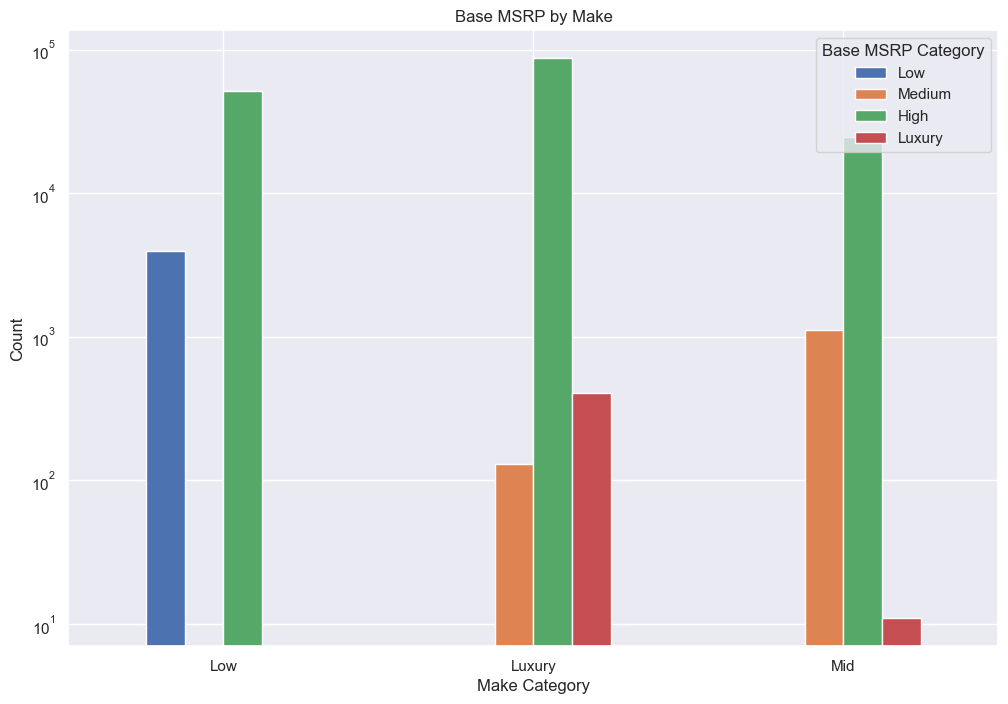

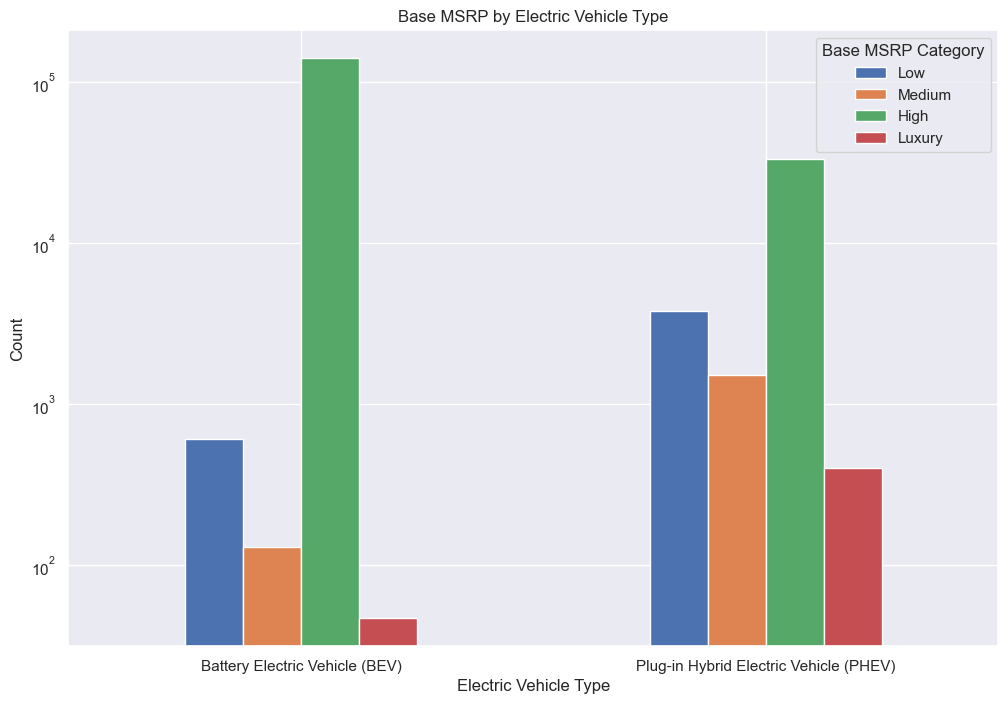

/var/folders/b2/fpf7pzvd35zcmkv3xj4n_nbm0000gn/T/ipykernel_3646/1086547404.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  msrp_category_count = characteristic_rules.pivot_table(index='Region', columns='Base MSRP Category', values='Count', aggfunc='sum', fill_value=0)


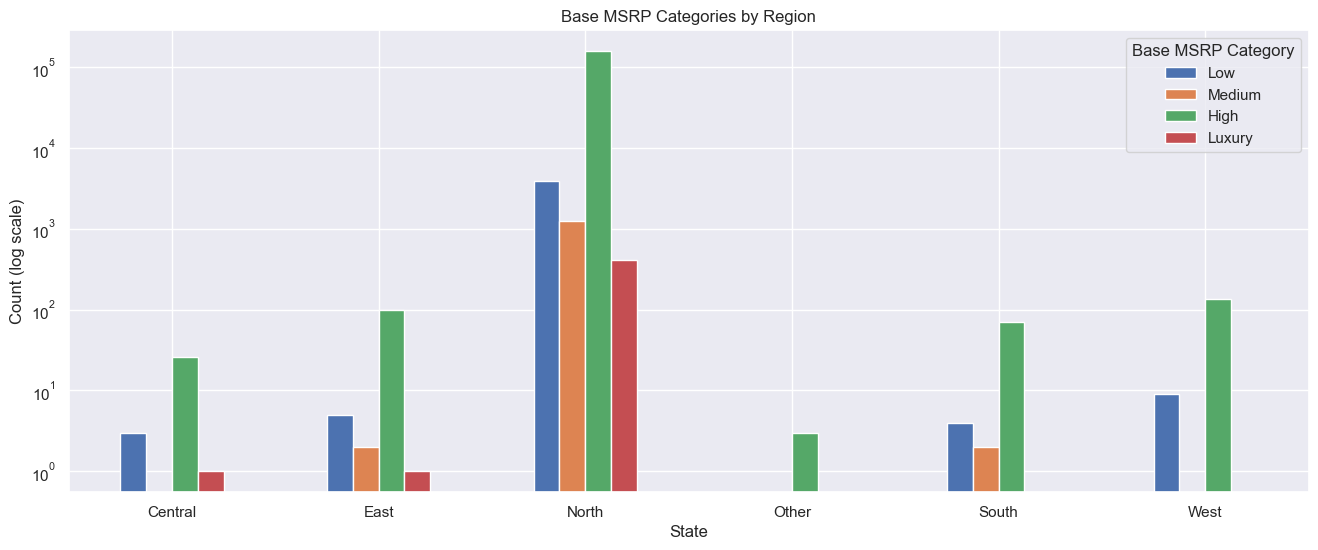

In [87]:
# Base MSRP by Make
base_msrp_by_make = generalised_data.groupby('Make Category')['Base MSRP Category'].value_counts().unstack().fillna(0)
base_msrp_by_make.plot(kind='bar', figsize=(12, 8))
plt.xlabel('Make Category')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.yscale('log')
plt.title('Base MSRP by Make')
plt.legend(title='Base MSRP Category')
plt.show()

# Base MSRP by Electric Vehicle Type
base_msrp_by_make = generalised_data.groupby('Electric Vehicle Type')['Base MSRP Category'].value_counts().unstack().fillna(0)
base_msrp_by_make.plot(kind='bar', figsize=(12, 8))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.yscale('log')
plt.title('Base MSRP by Electric Vehicle Type')
plt.legend(title='Base MSRP Category')
plt.show()

# Base MSRP Category by Region
msrp_category_count = characteristic_rules.pivot_table(index='Region', columns='Base MSRP Category', values='Count', aggfunc='sum', fill_value=0)
msrp_category_count.plot(kind='bar', figsize=(16, 6))
plt.xlabel('State')
plt.xticks(rotation=0)
plt.ylabel('Count (log scale)')
plt.yscale('log')
plt.title('Base MSRP Categories by Region')
plt.legend(title='Base MSRP Category')
plt.show()


## **Task - 2: Bottom-Up Computation**


#### **In-memory implementation of the BUC Algorithm**
- This algorithm implements the **Bottom-Up Cube (BUC)** method to compute a multi-dimensional data cube by recursively aggregating data across all combinations of dimensions. 
- It filters combinations based on a specified **minimum support** to avoid low-frequency groups, improving performance. The process involves sorting data by dimensions, aggregating unique values and their counts, and recursively exploring different combinations. 
- After computing the cube, the runtime is analyzed and visualized against different minimum support thresholds to show how performance changes with stricter filtering.

In [88]:
df = pd.read_csv('Electric_Vehicle_Data.csv')
# Data Cleaning
# Replace 0 MSRP with Average of Cars with similar Make and Model
df['Base MSRP'] = df['Base MSRP'].replace(0, np.nan)
df['Base MSRP'] = df.groupby(['Make', 'Model'])['Base MSRP'].transform(lambda x: x.fillna(x.mean()))
df['Base MSRP'] = df['Base MSRP'].fillna(df['Base MSRP'].mean())

#  Replace 0 Electric Range with Average of Cars with similar Make and Model
df['Electric Range'] = df['Electric Range'].replace(0, np.nan)
df['Electric Range'] = df.groupby(['Make', 'Model'])['Electric Range'].transform(lambda x: x.fillna(x.mean()))
df['Electric Range'] = df.groupby('Make')['Electric Range'].transform(lambda x: x.fillna(x.mean()))

# Remove Highly Specific Attributes
data = df.drop(columns=['VIN (1-10)', 'DOL Vehicle ID', 'Vehicle Location', '2020 Census Tract', 'City', 'Postal Code', "Electric Utility", "Legislative District", "County", "Model"])

range_features = data["Electric Range"].describe()
bins = [0, range_features["25%"], range_features["75%"], range_features["max"]]
label_names = ["low", "medium", "high"]
data["Electric Range"] = pd.cut(data["Electric Range"], bins=bins, labels=label_names)

# Model Year 
bins_year = [0, 2014, 2020, 2025]
labels_year = ['Before 2015', '2015-2020', '2021 and later']
data['Model Year'] = pd.cut(data['Model Year'], bins=bins_year, labels=labels_year, include_lowest=True)

# Base MSRP
bins_msrp = [0, 50000, 60000, 80000, 150000]
labels_msrp = ['Low', 'Medium', 'High', 'Luxury']
data['Base MSRP'] = pd.cut(data['Base MSRP'], bins=bins_msrp, labels=labels_msrp, include_lowest=True)

make_hierarchy = {
    'CHEVROLET': 'Low', 'KIA': 'Low', 'NISSAN': 'Low', 'FIAT': 'Low', 'TOYOTA': 'Low', 'HONDA': 'Low', 
    'CHRYSLER': 'Low', 'SMART': 'Low', 'LINCOLN': 'Low', 'MINI': 'Low', 'MITSUBISHI': 'Low', 'HYUNDAI': 'Low', 
    'DODGE': 'Low', 'GENESIS': 'Low', 'SUBARU': 'Low', 'GMC': 'Low', 'WHEEGO ELECTRIC CARS': 'Low', 
    'TH!NK': 'Low', 'VOLVO': 'Mid', 'FORD': 'Mid', 'LEXUS': 'Mid', 'CADILLAC': 'Mid', 'MAZDA': 'Mid', 
    'VOLKSWAGEN': 'Mid', 'RIVIAN': 'Mid', 'POLESTAR': 'Mid', 'LAND ROVER': 'Mid', 'FISKER': 'Mid', 
    'AZURE DYNAMICS': 'Mid', 'JAGUAR': 'Luxury', 'MERCEDES-BENZ': 'Luxury', 'PORSCHE': 'Luxury', 
    'AUDI': 'Luxury', 'BENTLEY': 'Luxury', 'ROLLS ROYCE': 'Luxury', 'LUCID': 'Luxury', 'TESLA': 'Luxury', 
    'ALFA ROMEO': 'Luxury'
}
data['Make'] = data['Make'].map(make_hierarchy)

region_mapping = {
    'North': ['WA', 'ID', 'MT', 'MN', 'WI', 'MI', 'ND', 'SD'],
    'East': ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA', 'DE', 'MD', 'DC', 'VA'],
    'South': ['TX', 'FL', 'GA', 'SC', 'NC', 'AL', 'MS', 'TN', 'LA', 'AR', 'KY'],
    'West': ['CA', 'OR', 'NV', 'UT', 'AZ', 'CO', 'NM', 'WY', 'AK', 'HI'],
    'Central': ['MO', 'IA', 'IN', 'IL', 'OH', 'NE', 'KS', 'OK'],
    'Other': ['AE', 'BC']
}

# Reverse the mapping for faster lookups
state_to_region = {state: region for region, states in region_mapping.items() for state in states}

# Apply the mapping to the DataFrame
data['State'] = df['State'].map(state_to_region)
data = data.dropna(how="any")

In [89]:
def aggregate(data):
    curr_column= data[:,0]
    unique,datacounts=np.unique(curr_column,return_counts=True)
    return unique,datacounts
def compute_cube(data, output, min_sup):
    dim = data.shape[1]
    if dim == 0:
        all_cube.append(output.copy())
        all_cube[-1].append(len(data))
        return

    if len(data) == 0:
        return

    # Sort only if necessary
    if len(data) > 1:
        idx = np.argsort(data[:, 0])
        data = data[idx]

    unique_attributes, datacount = aggregate(data)
    k = 0
    cardinality = len(unique_attributes)
    for i in range(cardinality):
        count = datacount[i]
        if count >= min_sup:
            output.append(data[k, 0])
            compute_cube(data[k:k + count, 1:], output, min_sup)
            output.pop()
        k += count

    output.append("ALL")
    compute_cube(data[:, 1:], output, min_sup)
    output.pop()

In [90]:
min_sup_list=[100,200,300,400,500]
run_time=[]

for min_sup in min_sup_list:
    output_rec = []
    all_cube = []
    start = time.time()
    compute_cube(data.values, output_rec, min_sup)
    end_time = time.time()

    if min_sup == 100:
        result = pd.DataFrame(all_cube)
        cols_name = list(data.columns)
        cols_name.append('count')
        result.columns = cols_name

    run_time.append(end_time - start)


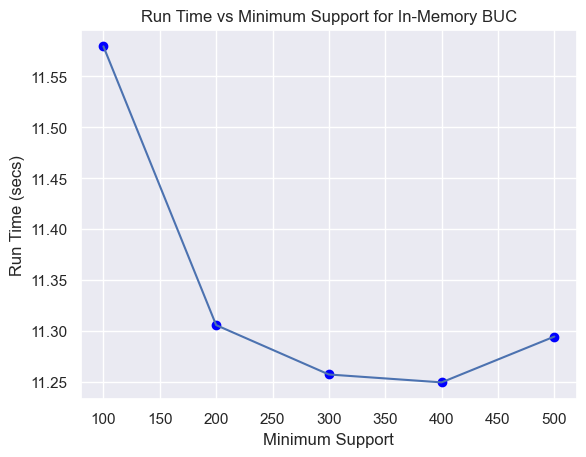

In [91]:
sns.set()
plt.figure()
plt.plot(min_sup_list,run_time)
plt.scatter(min_sup_list,run_time,marker='o',color='blue')
plt.title("Run Time vs Minimum Support for In-Memory BUC")
plt.xlabel("Minimum Support")
plt.ylabel("Run Time (secs)")
plt.show()

#### **Out-of-memory implementation of the BUC algorithm**
This algorithm performs **external memory-based data cube computation** for large datasets by using chunk-wise processing. It involves:
- **External Merge Sort**: Sorts large datasets that don't fit in memory by partitioning and merging sorted chunks.
- **Data Aggregation**: Groups data by an attribute, counting unique values.
- **Recursive Cube Computation**: Recursively computes the cube by considering different combinations of attributes and aggregating based on a user-specified minimum support threshold 
- **PageTable Class**: Manages paginated reading, sorting, and partitioning of data to optimize memory usage.
- **Performance Analysis**: Measures and plots the time taken to compute the cube for different memory allocations (page sizes).

In [92]:
data.to_csv("./processed_data.csv",index=False)

In [93]:
def merge_files(filename, df1, df2, attr):
    # Merge the two DataFrames based on the attribute
    merged_df = pd.concat([df1, df2]).sort_values(by=attr)
    
    # Write the merged DataFrame to the file
    merged_df.to_csv(filename, index=False)
def external_merge_sort(df, start, end, attr, numRows):
    if (end - start < numRows):
        df = df.sort_values(by=attr)
        return df
    
    mid = (end + start) // 2

    # Recursively sort and merge the two halves
    left_df = external_merge_sort(df.iloc[:mid-start+1], start, mid, attr, numRows)
    right_df = external_merge_sort(df.iloc[mid-start+1:], mid + 1, end, attr, numRows)
    
    # Merge the two halves
    merged_df = pd.concat([left_df, right_df]).sort_values(by=attr)
    
    return merged_df


In [94]:

def aggregate_page(df, attr):
    grouped = df.groupby(attr).size()
    return grouped.index.tolist(), grouped.values.tolist()

class PageTable:
    def __init__(self, filename, pageSize):
        self.filename = filename
        df_temp = pd.read_csv(filename)
        self.numRows = len(df_temp)
        self.col = df_temp.columns
        self.pageSize = pageSize
        self.numRowsBlock = self.pageSize

    def partitionAttr(self, attr):
        # print(f"Partitioning on attribute: {attr}")  # Debugging statement
        df = pd.read_csv(self.filename)
        
        # Perform the external merge sort if necessary
        if self.numRows > self.numRowsBlock:
            df = external_merge_sort(df, 0, self.numRows - 1, attr, self.numRowsBlock)
        
        # Aggregate the sorted data
        unique_attr, datacount = aggregate_page(df, attr)
        
        page_dict = {}
        pageNumber = 0
        pages = []
        
        for i, value in enumerate(unique_attr):
            count = datacount[i]
            page_df = df[df[attr] == value]
            pages.append(page_df)
            page_dict[f"{attr}_{i}"] = page_df
            pageNumber += 1
        
        return unique_attr, datacount, pages


In [95]:

all_cube = []
mins_up = 100

def compute(table, curr_rec, attr, subset):
    if attr is None:
        all_cube.append(curr_rec.copy())
        if len(subset) == 0:
            all_cube[-1].append(table.numRows)
        else:
            all_cube[-1].append(len(subset))
        return

    if len(subset) == 0:
        unique_attr, datacount, pages = table.partitionAttr(attr)
    else:
        subset = subset.sort_values(by=attr)
        unique_attr, datacount = aggregate_page(subset, attr)
    
    for i in range(len(unique_attr)):
        count = datacount[i]
        if len(subset) == 0:
            if count >= mins_up:
                page_df = pages[i]
                curr_rec.append(unique_attr[i])
                next_attr_index = list(table.col).index(attr) + 1
                if next_attr_index < len(table.col):
                    next_attr = table.col[next_attr_index]
                    compute(table, curr_rec, next_attr, page_df)
                else:
                    compute(table, curr_rec, None, page_df)
                curr_rec.pop()
        else:
            if count >= mins_up:
                curr_rec.append(unique_attr[i])
                next_attr_index = list(table.col).index(attr) + 1
                if next_attr_index < len(subset.columns):
                    next_attr = subset.columns[next_attr_index]
                    compute(table, curr_rec, next_attr, subset[subset[attr] == unique_attr[i]])
                else:
                    compute(table, curr_rec, None, subset[subset[attr] == unique_attr[i]])
                curr_rec.pop()
    
    curr_rec.append("ALL")
    next_attr_index = list(table.col).index(attr) + 1
    if next_attr_index < len(table.col):
        next_attr = table.col[next_attr_index]
        compute(table, curr_rec, next_attr, subset)
    else:
        compute(table, curr_rec, None, subset)
    curr_rec.pop()



In [96]:
page_size = [1000, 2500, 5000, 10000]
time_taken = []

for i in page_size:
    curr_rec = []
    subset = []
    all_cube = []
    table = PageTable("processed_data.csv", i)

    start = time.time()
    compute(table, curr_rec, list(table.col)[0], subset)
    end_time = time.time()

    time_taken.append(end_time - start)

    result = pd.DataFrame(all_cube)
    result.to_csv(f"result_{i}.csv", index=False)

### **Plot of allotted memory vs runtime**

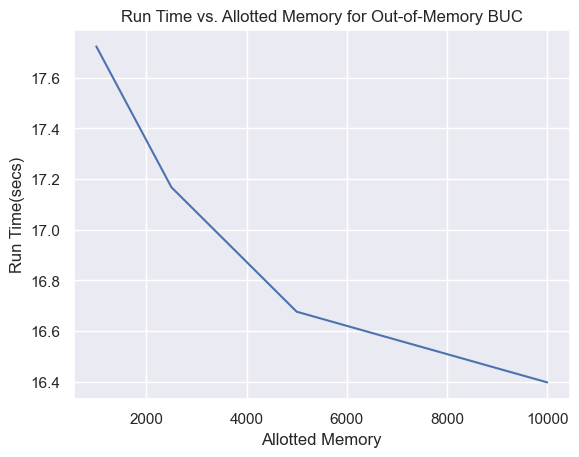

In [97]:
plt.figure()
plt.plot(page_size,time_taken)
plt.xlabel("Allotted Memory")
plt.ylabel("Run Time(secs)")
plt.title('Run Time vs. Allotted Memory for Out-of-Memory BUC')
plt.show()

### **Optimisation Technique on BUC**
This code uses a caching mechanism to efficiently analyze a dataset with varying minimum support thresholds. It processes the data by grouping and counting occurrences for each threshold, caching results to avoid redundant calculations. Computed results are stored in the cache with a unique key based on the function arguments to allow future reuse and reduce processing time. The time taken for each threshold is measured and printed.

 

In [106]:
# In-memory cache dictionary
cache = {}

# Define the DataFrame and minSupport values
minSupport_values = [100, 200, 300, 400, 500]
time_taken = []

for minSupport in minSupport_values:
    start_time = time.time()
    
    numDims = data.shape[1]  # Number of dimensions
    results = []

    for j in range(numDims):
        start = j
        end = j
        min_support = minSupport

        if end >= data.shape[1]:  # Prevent out-of-bounds access
            continue

        # Create a unique cache key based on the function arguments
        cache_key = (start, end, min_support)
        
        # Use cached results if available
        if cache_key in cache:
            results.extend(cache[cache_key])
            continue

        # Group by the current dimension and count occurrences
        countdf = data.groupby(data.columns[end], observed=False).size().reset_index(name='count').sort_values(by='count', ascending=False)
        temp_results = []

        for value, count in countdf.itertuples(index=False):
            if count >= min_support:
                tempdf = data[data[data.columns[end]] == value]
                tempdf_str = " ~ ".join(tempdf.iloc[0, start:end + 1].astype(str).values)

                if len(tempdf) >= min_support:
                    sub_results = []
                    sub_start = start
                    sub_end = end + 1

                    while sub_end < tempdf.shape[1]:
                        sub_cache_key = (sub_start, sub_end, min_support)
                        
                        if sub_cache_key in cache:
                            sub_results.extend(cache[sub_cache_key])
                            break

                        sub_countdf = tempdf.groupby(tempdf.columns[sub_end], observed=False).size().reset_index(name='count').sort_values(by='count', ascending=False)
                        for sub_value, sub_count in sub_countdf.itertuples(index=False):
                            if sub_count >= min_support:
                                sub_tempdf = tempdf[tempdf[tempdf.columns[sub_end]] == sub_value]
                                sub_tempdf_str = " ~ ".join(sub_tempdf.iloc[0, sub_start:sub_end + 1].astype(str).values)

                                if len(sub_tempdf) >= min_support:
                                    sub_results.append((sub_tempdf_str, sub_count))
                                    temp_results.append((sub_tempdf_str, sub_count))
                                    sub_results.extend(temp_results)

                        cache[sub_cache_key] = sub_results
                        sub_end += 1

                    temp_results.append((tempdf_str, count))
                    temp_results.extend(sub_results)

        # Store the result in the cache
        cache[cache_key] = temp_results
        results.extend(temp_results)

    end_time = time.time()
    time_taken.append(end_time - start_time)

# Print the results
for minSupport, duration in zip(minSupport_values, time_taken):
    print(f"minSupport: {minSupport}, Time taken: {duration:.2f} seconds")

minSupport: 100, Time taken: 0.54 seconds
minSupport: 200, Time taken: 0.53 seconds
minSupport: 300, Time taken: 0.52 seconds
minSupport: 400, Time taken: 0.52 seconds
minSupport: 500, Time taken: 0.52 seconds


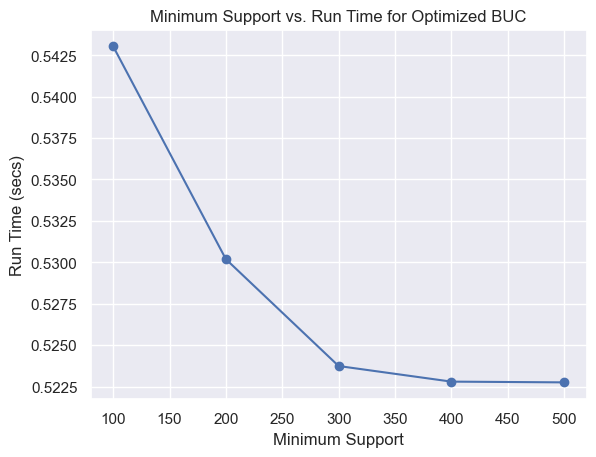

In [108]:

# Plotting minSupport vs. Time Taken
plt.plot(minSupport_values, time_taken, marker='o')
plt.xlabel('Minimum Support')
plt.ylabel('Run Time (secs)')
plt.title('Minimum Support vs. Run Time for Optimized BUC')
plt.grid(True)
plt.show()